In [54]:
import os
import glob
import cmweather
import numpy as np
import pandas as pd
import xarray as xr
import xradar as xd
import radarx as rx

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from netCDF4 import num2date
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
import warnings
warnings.filterwarnings("ignore")

In [2]:
print(rx.__version__)

0.2.2.dev7


In [3]:
# Setup working directories
basedir = "/Users/syed44/Downloads/Others/IMD_JAIPUR/"
data_dir = os.path.join(basedir, "CFRAD_PCF/")
out_dir = os.path.join(basedir, "CFRAD_PCF2")
os.makedirs(out_dir, exist_ok=True)

In [4]:
files = sorted(glob.glob(os.path.join(data_dir, "*nc*")))
print(f"Number of sweeps: {len(files)}")

Number of sweeps: 121


In [5]:
files[:5]

['/Users/syed44/Downloads/Others/IMD_JAIPUR/CFRAD_PCF/cfrad_JPR220822000253-IMD-B.nc',
 '/Users/syed44/Downloads/Others/IMD_JAIPUR/CFRAD_PCF/cfrad_JPR220822001242-IMD-B.nc',
 '/Users/syed44/Downloads/Others/IMD_JAIPUR/CFRAD_PCF/cfrad_JPR220822002253-IMD-B.nc',
 '/Users/syed44/Downloads/Others/IMD_JAIPUR/CFRAD_PCF/cfrad_JPR220822003253-IMD-B.nc',
 '/Users/syed44/Downloads/Others/IMD_JAIPUR/CFRAD_PCF/cfrad_JPR220822004253-IMD-B.nc']

This data is generated using the other notebook that is named as [PCF_CFRAD.ipynb]("./PCF_CFRAD.ipynb") in this repo

In [6]:
dtree = xd.io.open_cfradial1_datatree(files[0])

In [7]:
dtree = dtree.xradar.georeference()

In [15]:
def ref_filter(ds, field="DBZ"):
    ds = ds.where(((ds[field] >= -10) & (ds[field] <= 65)) & ((ds.WIDTH>=0) & (ds.WIDTH<8)))
    ds = ds.where((ds.VEL>-70)&(ds.VEL<70))
    return ds

In [9]:
dtree = dtree.xradar.map_over_sweeps(ref_filter, 'REF')

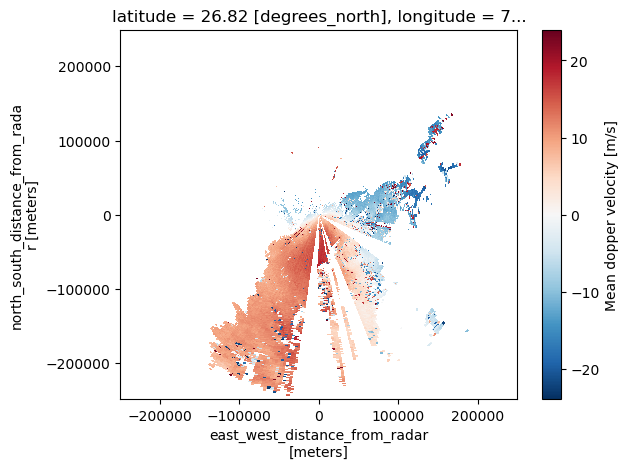

In [10]:
dtree['sweep_0']['VEL'].plot(x='x', y='y')

In [11]:
xlim = 250e3
zlim = (0, 10000)
hres = 1000
vres = 250

ds = dtree.radarx.to_grid(data_vars=['REF', 'ZDR', 'VEL'],
                          pseudo_cappi=False,
                          x_lim=(-xlim, xlim),
                          y_lim=(-xlim, xlim),
                          z_lim=zlim,
                          x_step=hres,
                          y_step=hres,
                          z_step=vres,
                          x_smth=0.5,
                          y_smth=0.5,
                          z_smth=4,)

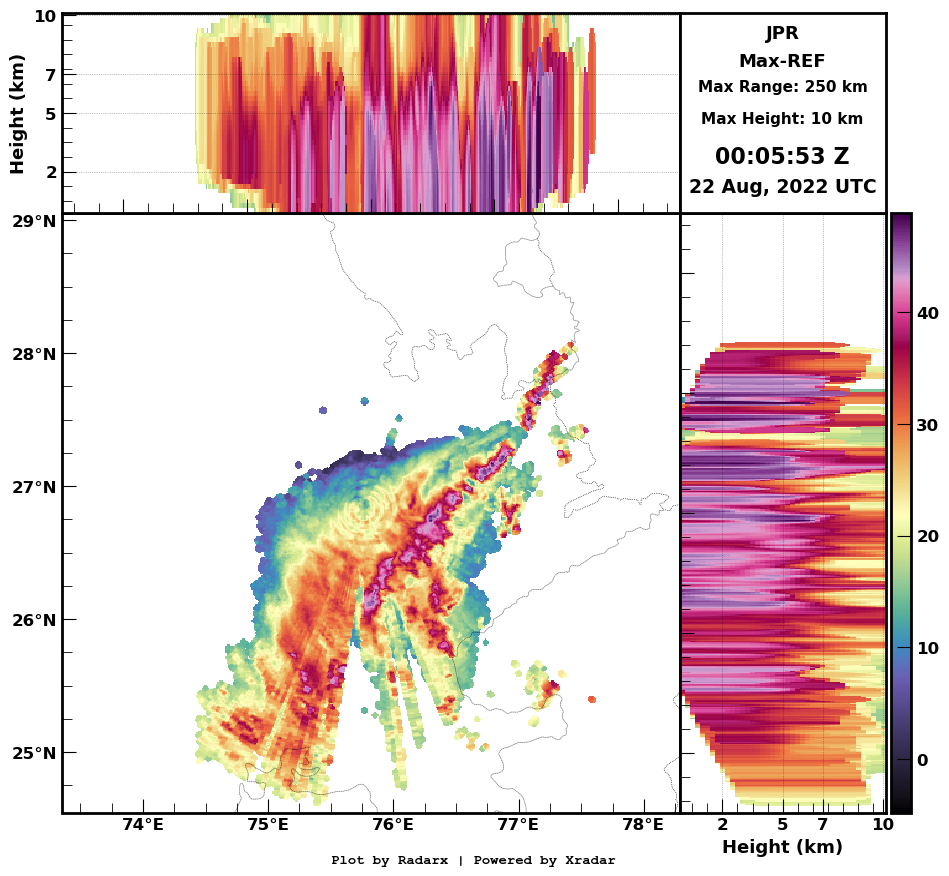

In [12]:
fig = ds.radarx.plot_max_cappi('REF', add_slogan=True)

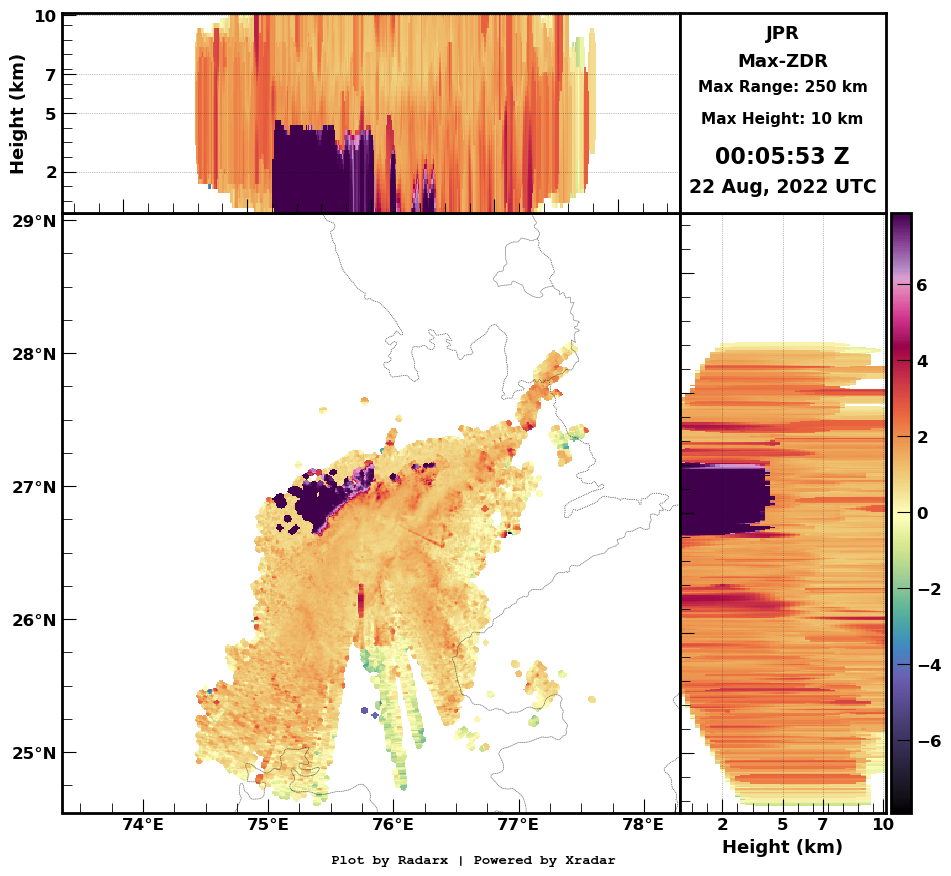

In [12]:
ds.radarx.plot_max_cappi('ZDR', add_slogan=True)

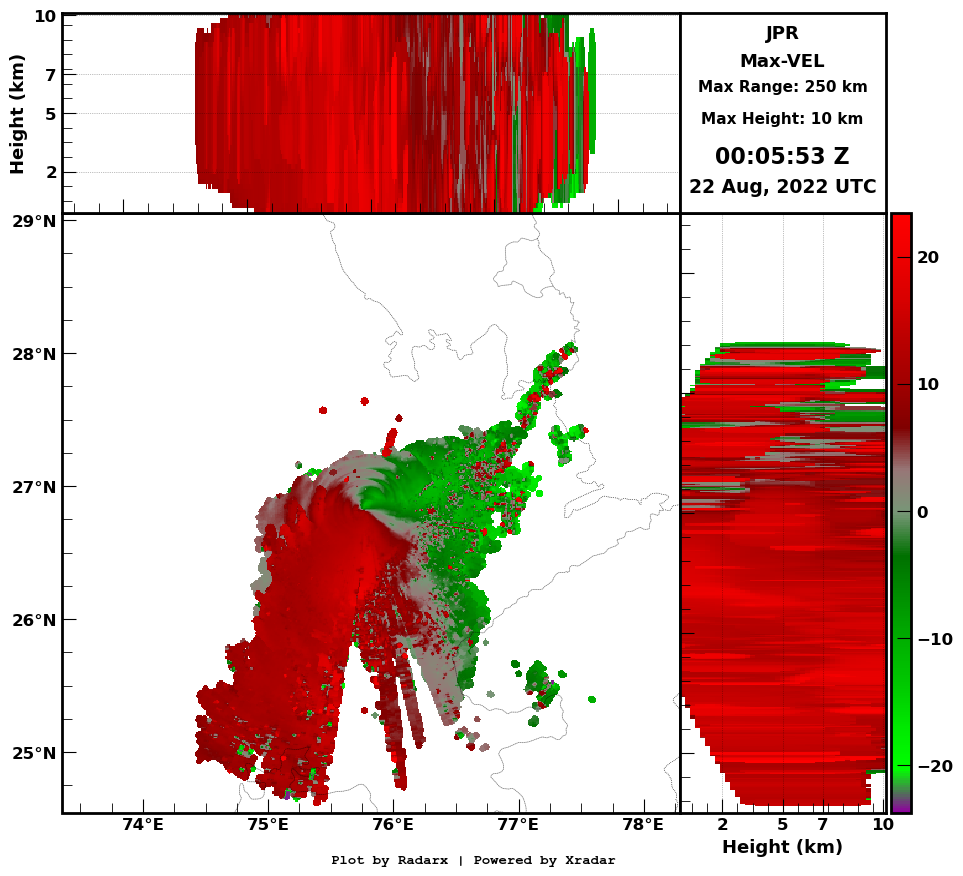

In [13]:
ds.radarx.plot_max_cappi('VEL', cmap="NWSVel",  add_slogan=True)

In [ ]:
ds['REF'].isel(z=4).plot.contourf(levels=range(71), cmap='HomeyerRainbow')

In [62]:
out_dir = "/Users/syed44/Downloads/Others/IMD_JAIPUR/MAX_CAPPI"
os.makedirs(out_dir, exist_ok=True)

In [ ]:
frame_files = []
for idx, file in enumerate(files):
    print(f"Processing {idx, os.path.basename(file)}")
    dtree = xd.io.open_cfradial1_datatree(file, decode_times=False)
    dtree = dtree.xradar.map_over_sweeps(ref_filter, 'REF')
    ds = dtree.radarx.to_grid(data_vars=['REF'],
                              pseudo_cappi=False,
                              x_lim=(-xlim, xlim),
                              y_lim=(-xlim, xlim),
                              z_lim=zlim,
                              x_step=hres,
                              y_step=hres,
                              z_step=vres,
                              x_smth=0.5,
                              y_smth=0.5,
                              z_smth=4,)

    units = "seconds since "+str(
        pd.to_datetime(
            dtree['sweep_0']['time'][0].attrs['units'].strip('seconds since ')))
    ds['time'] = num2date(
        dtree['sweep_0']['time'][0].values,
        units
    )
    
    # Create a plot for the frame
    fig = rx.vis.plot_maxcappi(
        ds, 'REF', vmin=0, vmax=70, range_rings=True, show_figure=False, add_slogan=True)
    frame_path = os.path.join(out_dir, f"frame_{idx}.png")
    fig.savefig(frame_path)  # Save frame as PNG
    plt.close(fig)  # Close figure to free memory
    frame_files.append(frame_path)

In [80]:
from PIL import Image

In [84]:
# Create an animated GIF
frames = [Image.open(frame) for frame in frame_files]
gif_path = "radar_animation_imd_jaipur_22_aug.gif"
frames[0].save(
    gif_path,
    save_all=True,
    append_images=frames[1:],
    duration=300,  # Duration per frame in milliseconds
    loop=0  # Infinite loop
)

print(f"Animation saved as {gif_path}")

Animation saved as radar_animation_imd_jaipur_22_aug.gif


In [82]:
from IPython.display import Image as im

In [85]:
im(url='radar_animation_imd_jaipur_22_aug.gif') 